# Prototype calculation of cabelling and mixing of density from LLC4320 data
[Podaac description](https://podaac.jpl.nasa.gov/announcements/2021-04-30-Pre-SWOT-L4-Hourly-MITgcm-LLC4320-Native-1/48-degree-Grid-Oceanographic-V1.0-Datasets-Release)

In [19]:
from dask_gateway import Gateway
gateway = Gateway()
options = gateway.cluster_options()

# set the options programatically, or through their HTML repr
options.worker_memory = 30  # 10 GB of memory per worker.

# Create a cluster with those options
cluster = gateway.new_cluster(options)
cluster.scale(30)
client = cluster.get_client()

In [20]:
client

Connection method: Cluster object,Cluster type: dask_gateway.GatewayCluster
Dashboard: /services/dask-gateway/clusters/prod.4b28d5a714eb4a9c8dd44b14a18a4d27/status,


In [32]:
cluster.close()
client.close()

In [1]:
import xarray as xr
import numpy as np
import dask.array as dsa
import matplotlib.pyplot as plt
import fastjmd95
import pop_tools
import gcsfs
import xmitgcm
from xmitgcm.llcreader.llcmodel import faces_dataset_to_latlon
from typing import Annotated

In [2]:
from intake import open_catalog

url = "https://raw.githubusercontent.com/pangeo-data/pangeo-datastore/master/intake-catalogs/ocean/llc4320.yaml"
cat = open_catalog(url)
sst  = cat["LLC4320_SST"].to_dask()
sss  = cat["LLC4320_SSS"].to_dask()
grid_ds = cat["LLC4320_grid"].to_dask()

In [3]:
merge = xr.merge([sst, sss.SSS, grid_ds])
merge['SSD'] = fastjmd95.rho(merge.SSS, merge.SST, 0)

In [4]:
merge_rechunked = merge.chunk({'time':1, 'j':12960, 'i':17280, 'i_g':17280, 'j_g':12960})

In [5]:
coords = merge_rechunked.coords.to_dataset().reset_coords()
ds = merge_rechunked.reset_coords(drop=True)
ds

<xarray.Dataset>
Dimensions:  (time: 9030, face: 13, j: 4320, i: 4320, k_p1: 2, j_g: 4320,
              i_g: 4320)
Coordinates:
  * face     (face) int64 0 1 2 3 4 5 6 7 8 9 10 11 12
  * i        (i) int64 0 1 2 3 4 5 6 7 ... 4313 4314 4315 4316 4317 4318 4319
  * j        (j) int64 0 1 2 3 4 5 6 7 ... 4313 4314 4315 4316 4317 4318 4319
  * time     (time) datetime64[ns] 2011-09-13 ... 2012-09-23T05:00:00
  * i_g      (i_g) int64 0 1 2 3 4 5 6 7 ... 4313 4314 4315 4316 4317 4318 4319
  * j_g      (j_g) int64 0 1 2 3 4 5 6 7 ... 4313 4314 4315 4316 4317 4318 4319
  * k_p1     (k_p1) int64 0 1
Data variables:
    SST      (time, face, j, i) float32 dask.array<chunksize=(1, 1, 4320, 4320), meta=np.ndarray>
    SSS      (time, face, j, i) float32 dask.array<chunksize=(1, 1, 4320, 4320), meta=np.ndarray>
    SSD      (time, face, j, i) float64 dask.array<chunksize=(1, 1, 4320, 4320), meta=np.ndarray>
Attributes:
    Conventions:  CF-1.6
    history:      Created by calling `open_mdsdataset(llc_method='smallchunks...
    source:       MITgcm
    title:        netCDF wrapper of MITgcm MDS binary data

# BIHARMONIC/LAPLACIAN ROUTINE

## Biharmonic (borrowed from Paige/POP data)

In [45]:
ds.dyG

<xarray.DataArray 'dyG' (j: 12960, i_g: 17280)>
dask.array<concatenate, shape=(12960, 17280), dtype=float32, chunksize=(4320, 4320), chunktype=numpy.ndarray>
Coordinates: (12/14)
  * j        (j) int64 0 1 2 3 4 5 6 ... 12954 12955 12956 12957 12958 12959
  * i_g      (i_g) int64 0 1 2 3 4 5 6 ... 17274 17275 17276 17277 17278 17279
    PHrefC   float32 15.4
    Z        float32 -1.57
    Zl       float32 -1.0
    Zu       float32 -2.14
    ...       ...
    dyG      (j, i_g) float32 dask.array<chunksize=(4320, 4320), meta=np.ndarray>
    hFacW    (j, i_g) float32 dask.array<chunksize=(4320, 4320), meta=np.ndarray>
    k        int64 1
    k_l      int64 1
    k_u      int64 1
    rAw      (j, i_g) float32 dask.array<chunksize=(4320, 4320), meta=np.ndarray>
Attributes:
    coordinate:     YC XG
    long_name:      cell y size
    standard_name:  cell_y_size_at_u_location
    units:          m

In [44]:
ds.dxG

<xarray.DataArray 'dxG' (j_g: 12960, i: 17280)>
dask.array<concatenate, shape=(12960, 17280), dtype=float32, chunksize=(4320, 4320), chunktype=numpy.ndarray>
Coordinates: (12/14)
  * i        (i) int64 0 1 2 3 4 5 6 ... 17274 17275 17276 17277 17278 17279
  * j_g      (j_g) int64 0 1 2 3 4 5 6 ... 12954 12955 12956 12957 12958 12959
    PHrefC   float32 15.4
    Z        float32 -1.57
    Zl       float32 -1.0
    Zu       float32 -2.14
    ...       ...
    dyC      (j_g, i) float32 dask.array<chunksize=(4320, 4320), meta=np.ndarray>
    hFacS    (j_g, i) float32 dask.array<chunksize=(4320, 4320), meta=np.ndarray>
    k        int64 1
    k_l      int64 1
    k_u      int64 1
    rAs      (j_g, i) float32 dask.array<chunksize=(4320, 4320), meta=np.ndarray>
Attributes:
    coordinate:     YG XC
    long_name:      cell x size
    standard_name:  cell_x_size_at_v_location
    units:          m

In [9]:
#from Paige's code: The biharmonic horiz diffusion routine
#https://github.com/ocean-transport/cesm-air-sea/blob/master/biharmonic_tendency.ipynb

# raw grid geometry
work1 = (ds['dxG'].values / #m
         ds['dyG'].values) #m
tarea = ds['rA'].values # m**2
tarea_r = np.ma.masked_invalid(tarea**-1).filled(0.) # 1/area of T cells
dtn = work1*tarea_r # coefficient of north point in 5-point stencil
dts = np.roll(work1,-1,axis=0)*tarea_r # coeff of south point in 5-point stencil

work1 = (ds['HTE'].values / # HTE: cell widths on East sides of T cells (cm)
         ds['HUS'].values) # HUS: cell widths on South sides of U cells (cm)
dte = work1*tarea_r # coeff of east point in 5-point stencil
dtw = np.roll(work1,-1,axis=1)*tarea_r # coeff of west point in 5-point stencil

kmt = ds['KMT'].values # KMT: k-index of deepest grid cell on T grid (where k is the depth level)

# boundary conditions
kmt_ = kmt > 1 # k=1 is the surface, so this sets all subsurface levels to True
kmtn = np.roll(kmt_,-1,axis=0)
kmts = np.roll(kmt_,1,axis=0)
kmte = np.roll(kmt_,-1,axis=1)
kmtw = np.roll(kmt_,1,axis=1)
cn = np.where(kmt_ & kmtn, dtn, 0.) # where both kmt_ and kmtn are True, set value equal to dtn, else set to 0 -->
# --> essentially sets up a mask for land/surface points
cs = np.where(kmt_ & kmts, dts, 0.)
ce = np.where(kmt_ & kmte, dte, 0.)
cw = np.where(kmt_ & kmtw, dtw, 0.)

# Find single index where there's a min of squared latitude --> so this is probably the lat of equator
j_eq = np.argmin(ds['ULAT'].values[:,0]**2) # ULAT: array of U-grid latitudes (degrees North)
j_eq.shape

# Area of T cells / area of U cell at the equator, all raised to 1.5 power
# this is because the mixing scheme assumes the grid spacing that is at the equator, so coeffs are 1 at equator and reduce toward the poles
ahf = (tarea / ds['UAREA'].values[j_eq, 0])**1.5 # UAREA: area of U cells (cm**2)
ahf[kmt <= 1] = 0.

def laplacian(T, cn, cs, ce, cw):
    cc = -(cn + cs + ce + cw) # cn,cs,ce,cw are coeffs for laplacian
    return (
        cc * T +
        cn * np.roll(T, -1, axis=-2) +
        cs * np.roll(T, 1, axis=-2) +
        ce * np.roll(T, -1, axis=-1) +
        cw * np.roll(T, 1, axis=-1)          
    )

def biharmonic_tendency(T, ahf, cn, cs, ce, cw):
    ah=-3e17 # horizontal tracer mixing coefficient 
    d2tk = ahf * laplacian(T, cn, cs, ce, cw) # take laplacian of T, multiplying by grid factor due to equator
    return ah * laplacian(d2tk, cn, cs, ce, cw) # take laplacian of laplacian of T

KeyError: 'HTE'

In [ ]:
arr = [ahf, cn, cs, ce, cw]
for arr_type in arr:
    if str(type(arr_type)) == "<class 'numpy.ndarray'>":
        print("True")
    else:
        print("not ndarray")


## Laplacian borrowed from GCM-Filters MOM5 routine

In [6]:
ds_rechunked = ds

In [7]:
import xgcm
grid = xgcm.Grid(ds_rechunked.drop_dims('time'), coords={'X': {'center': 'i', 'left': 'i_g'}, 
                             'Y': {'center': 'j', 'left': 'j_g'}},
                             periodic=['X'])
grid

<xgcm.Grid>
X Axis (periodic, boundary=None):
  * center   i --> left
  * left     i_g --> center
Y Axis (not periodic, boundary=None):
  * center   j --> left
  * left     j_g --> center

In [8]:
wet_mask = (coords.hFacC > 0)
dxc = grid.interp(coords.dxC, 'X') #dxt equivalent
dyc = grid.interp(coords.dyC, 'Y') #dyt equivalent
dxg = grid.interp(coords.dxG, 'X') #dxu equivalent
dyg = grid.interp(coords.dyG, 'Y') #dyu equivalent
area = coords.rA
kappa = 10 #m^2/s

In [9]:
@xgcm.as_grid_ufunc(dask="parallelized")
def Laplacian(
    wet_mask: Annotated[np.ndarray, "(Y:center, X:center)"],
    dxc:      Annotated[np.ndarray, "(Y:center, X:center)"],
    dyc:      Annotated[np.ndarray, "(Y:center, X:center)"],
    dxg:      Annotated[np.ndarray, "(Y:left, X:left)"],
    dyg:      Annotated[np.ndarray, "(Y:left, X:left)"],
    area:     Annotated[np.ndarray, "(Y:center, X:center)"],
    tracer:   Annotated[np.ndarray, "(Y:center, X:center)"],
) ->          Annotated[np.ndarray, "(Y:center, X:center)"]:
    
    """Laplacian routine for MOM5 adapted to MITgcm LLC4320.
    MOM5 uses a Northeast convention B-grid, where velocity point U(i,j) is NE of tracer point T(i,j).
    MITgcm uses a C-grid where velocity point U(i_g, j_g) is on the cell faces and tracer point T(i,i)
    is in the cell center.
    
    Attributes
    __________
    For information on MITgcm discretization see: 
    https://mitgcm.readthedocs.io/en/latest/algorithm/algorithm.html#spatial-discretization-of-the-dynamical-equations
    
    For information on MITfcm horizontal grid see: https://mitgcm.readthedocs.io/en/latest/algorithm/horiz-grid.html
    
    wet_mask: Mask array, 1 for ocean, 0 for land
    dxc: width in x see fig 2.8 b), model diagnostic dxC
    dyc: height in y see fig 2.8 b), model diagnostic dyC
    dxu: width in x see fig 2.8 a), model diagnostic dxG
    dyu: height in see fig 2.8 a), model diagnostic dyG
    area_t: area of T-cell, dxt*dyt
    """    
    #x_wet_mask = wet_mask * np.roll(wet_mask, -1, axis=-1)
    #y_wet_mask = wet_mask * np.roll(wet_mask, -1, axis=-2)
    y_wet_mask = wet_mask * np.roll(wet_mask, -1, axis=-1) #order of index: (j,i)?
    x_wet_mask = wet_mask * np.roll(wet_mask, -1, axis=-2)

    tracer = np.nan_to_num(tracer)
    
    fx = 2 * (np.roll(tracer, -1, axis=-2) - tracer)
    #dxg_interp = grid.interp(dxg, 'X')
    fx /= dxg + np.roll(dxg, 1, axis=-1)
    fx *= x_wet_mask
    
    fy = 2 * (np.roll(tracer, -1, axis=-1) - tracer)
    #dyg_interp = grid.interp(dyg, 'Y', bounadry='fill')
    fy /= dyg + np.roll(dyg, 1, axis=-2)
    fy *= y_wet_mask

    out1 = fx * 0.5 * (dyc + np.roll(dyc, -1, axis=-2))
    out1 -= (
        np.roll(fx, 1, axis=-2) * 0.5 * (dyc + np.roll(dyc, 1, axis=-2))
    )
    out1 /= area

    out2 = fy * 0.5 * (dxc + np.roll(dxc, -1, axis=-1))
    out2 -= (
        np.roll(fy, 1, axis=-1) * 0.5 * (dxc + np.roll(dxc, 1, axis=-1))
    )
    out2 /= area
    return out1 + out2

In [10]:
axis = 7*[('Y','X')]

# 1) Calculate tendency of SST and and SSS from mixing <a class="anchor" id="first-bullet"> </a>

In [11]:
drhodt = xr.apply_ufunc(fastjmd95.drhodt, ds_rechunked.SSS, ds_rechunked.SST, 0,
                        output_dtypes=[ds_rechunked.SST.dtype],
                        dask='parallelized').reset_coords(drop=True)#.load()
drhods = xr.apply_ufunc(fastjmd95.drhods, ds_rechunked.SSS, ds_rechunked.SST, 0,
                        output_dtypes=[ds_rechunked.SSS.dtype],
                        dask='parallelized').reset_coords(drop=True)#.load()

In [12]:
ds['drhodt'] = drhodt
ds['drhods'] = drhods

In [13]:
ds

<xarray.Dataset>
Dimensions:  (time: 9030, face: 13, j: 4320, i: 4320, i_g: 4320, j_g: 4320,
              k_p1: 2)
Coordinates:
  * face     (face) int64 0 1 2 3 4 5 6 7 8 9 10 11 12
  * i        (i) int64 0 1 2 3 4 5 6 7 ... 4313 4314 4315 4316 4317 4318 4319
  * j        (j) int64 0 1 2 3 4 5 6 7 ... 4313 4314 4315 4316 4317 4318 4319
  * time     (time) datetime64[ns] 2011-09-13 ... 2012-09-23T05:00:00
  * i_g      (i_g) int64 0 1 2 3 4 5 6 7 ... 4313 4314 4315 4316 4317 4318 4319
  * j_g      (j_g) int64 0 1 2 3 4 5 6 7 ... 4313 4314 4315 4316 4317 4318 4319
  * k_p1     (k_p1) int64 0 1
Data variables:
    SST      (time, face, j, i) float32 dask.array<chunksize=(1, 1, 4320, 4320), meta=np.ndarray>
    SSS      (time, face, j, i) float32 dask.array<chunksize=(1, 1, 4320, 4320), meta=np.ndarray>
    SSD      (time, face, j, i) float64 dask.array<chunksize=(1, 1, 4320, 4320), meta=np.ndarray>
    drhodt   (time, face, j, i) float32 dask.array<chunksize=(1, 1, 4320, 4320), meta=np.ndarray>
    drhods   (time, face, j, i) float32 dask.array<chunksize=(1, 1, 4320, 4320), meta=np.ndarray>
Attributes:
    Conventions:  CF-1.6
    history:      Created by calling `open_mdsdataset(llc_method='smallchunks...
    source:       MITgcm
    title:        netCDF wrapper of MITgcm MDS binary data

In [18]:
def create_lap_terms(sst, sss, ssd, drhodt, drhods, face_layer=None):
    """Function to output the four tendency terms for each face"""
    slct = dict(face=face_layer)
    
    SST_lap = kappa * Laplacian(grid, wet_mask.isel(**slct), dxc.isel(**slct), dyc.isel(**slct), dxg.isel(**slct), 
                                dyg.isel(**slct), area.isel(**slct), sst.isel(**slct), axis=axis)
    SSS_lap = kappa * Laplacian(grid, wet_mask.isel(**slct), dxc.isel(**slct), dyc.isel(**slct), dxg.isel(**slct), 
                                dyg.isel(**slct), area.isel(**slct), sss.isel(**slct), axis=axis)
    dens_tend = (drhodt.isel(**slct) * SST_lap + drhods.isel(**slct) * SSS_lap)
    rho_lap = kappa * Laplacian(grid, wet_mask.isel(**slct), dxc.isel(**slct), dyc.isel(**slct), dxg.isel(**slct), 
                                dyg.isel(**slct), area.isel(**slct), ssd.isel(**slct), axis=axis)
    cabbeling = dens_tend - rho_lap
    
    
    new_ds = xr.merge([(SST_lap*drhodt.isel(**slct)).rename('sst'),
                      (SSS_lap*drhods.isel(**slct)).rename('sss'),
                       rho_lap.rename('rho_lap'), cabbeling.rename('cabbeling')])
    return (new_ds)

In [15]:
import warnings
warnings.filterwarnings("ignore")

In [19]:
#this cell iterates through the 13 faces and assigns the output ds from the `create_lap_terms` function
#to the corresponding face object name
faces = list(['face0','face1','face2','face3',
              'face4','face5','face6','face7',
              'face8','face9','face10','face11','face12',])

lap_terms_ds = []

#loop to create list of datasets
for i in np.arange(0,13): #ds.face.values:
    lap_terms_ds.append(create_lap_terms(ds.SST, ds.SSS, ds.SSD, ds.drhodt, ds.drhods, face_layer=i))

#loop to assign each ds in the list to the corresponding object name
for (item, layer) in zip(lap_terms_ds, faces):
    globals()[layer] = item

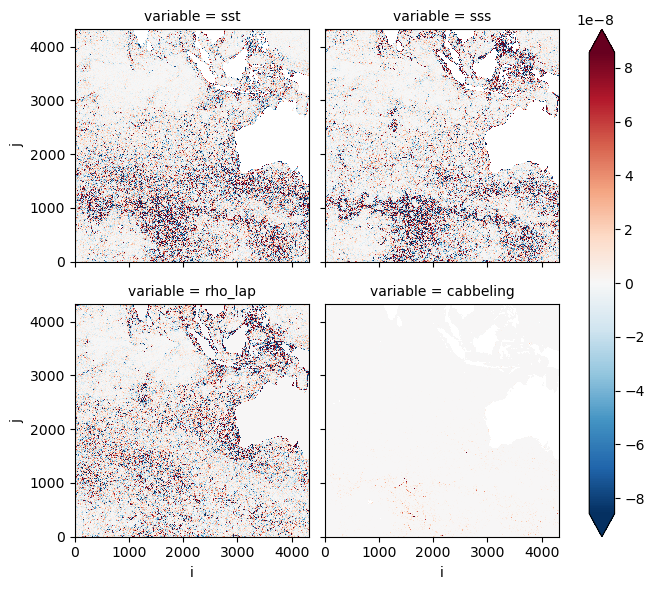

In [20]:
face4.isel(time=2000).to_array().plot(col='variable', col_wrap=2, robust=True);

In [21]:
#check residual for random face during random timestep
residual = face10.rho_lap + face10.cabbeling - face10.sst - face10.sss

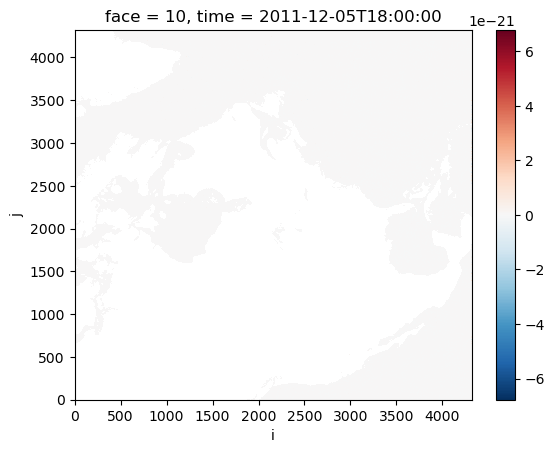

In [22]:
residual.isel(time=2010).plot();

# 2) Convert to density tendency <a class="anchor" id='second-bullet'> </a>

$$
\frac{\partial \rho}{\partial \theta} M(\theta) + \frac{\partial \rho}{\partial S} M(S)
$$

In [14]:
rho = ds_rechunked.SSD

In [15]:
rho

<xarray.DataArray 'SSD' (time: 9030, j: 12960, i: 17280)>
dask.array<transpose, shape=(9030, 12960, 17280), dtype=float64, chunksize=(1, 12960, 17280), chunktype=numpy.ndarray>
Coordinates: (12/19)
  * i        (i) int64 0 1 2 3 4 5 6 ... 17274 17275 17276 17277 17278 17279
  * j        (j) int64 0 1 2 3 4 5 6 ... 12954 12955 12956 12957 12958 12959
  * time     (time) datetime64[ns] 2011-09-13 ... 2012-09-23T05:00:00
    CS       (j, i) float32 dask.array<chunksize=(12960, 17280), meta=np.ndarray>
    Depth    (j, i) float32 dask.array<chunksize=(12960, 17280), meta=np.ndarray>
    PHrefC   float32 15.4
    ...       ...
    hFacC    (j, i) float32 dask.array<chunksize=(12960, 17280), meta=np.ndarray>
    iter     (time) int64 dask.array<chunksize=(1,), meta=np.ndarray>
    k        int64 1
    k_l      int64 1
    k_u      int64 1
    rA       (j, i) float32 dask.array<chunksize=(12960, 17280), meta=np.ndarray>

In [16]:
drhodt = xr.apply_ufunc(fastjmd95.drhodt, ds_rechunked.SSS, ds_rechunked.SST, 0,
                        output_dtypes=[ds_rechunked.SST.dtype],
                        dask='parallelized').reset_coords(drop=True)#.load()
drhods = xr.apply_ufunc(fastjmd95.drhods, ds_rechunked.SSS, ds_rechunked.SST, 0,
                        output_dtypes=[ds_rechunked.SSS.dtype],
                        dask='parallelized').reset_coords(drop=True)#.load()

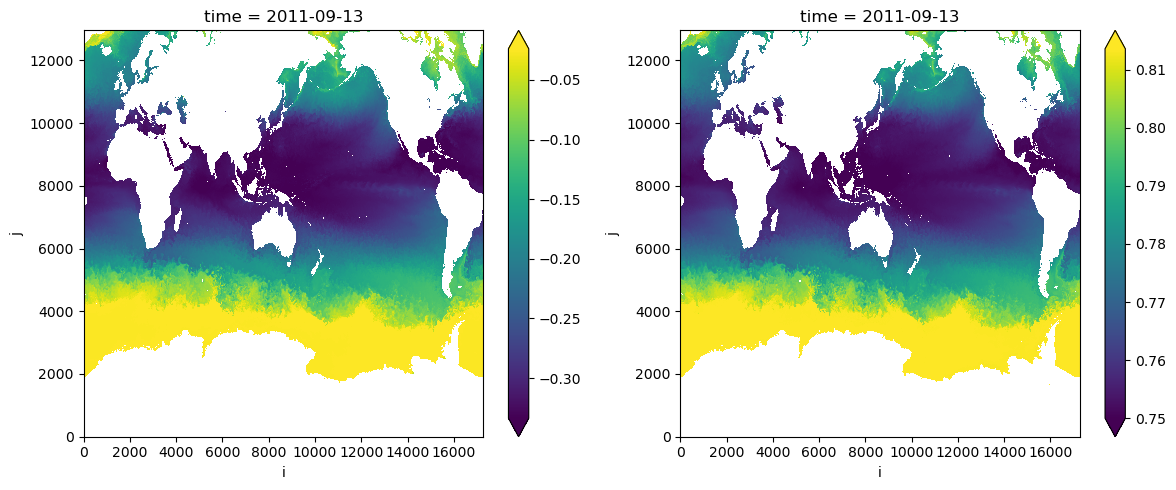

In [17]:
fig, (ax0,ax1) = plt.subplots(1,2, figsize=(12,5))
drhodt.isel(time=0).plot(robust=True, ax=ax0)
drhods.isel(time=0).plot(robust=True, ax=ax1)
plt.tight_layout();

In [18]:
dens_tend = (drhodt * SST_lap + drhods * SSS_lap)
dens_tend

<xarray.DataArray (time: 9030, j: 12960, i: 17280)>
dask.array<add, shape=(9030, 12960, 17280), dtype=float64, chunksize=(1, 12960, 17280), chunktype=numpy.ndarray>
Coordinates: (12/19)
  * i        (i) int64 0 1 2 3 4 5 6 ... 17274 17275 17276 17277 17278 17279
  * j        (j) int64 0 1 2 3 4 5 6 ... 12954 12955 12956 12957 12958 12959
  * time     (time) datetime64[ns] 2011-09-13 ... 2012-09-23T05:00:00
    PHrefC   float32 15.4
    Z        float32 -1.57
    Zl       float32 -1.0
    ...       ...
    SN       (j, i) float32 dask.array<chunksize=(12960, 17280), meta=np.ndarray>
    XC       (j, i) float32 dask.array<chunksize=(12960, 17280), meta=np.ndarray>
    YC       (j, i) float32 dask.array<chunksize=(12960, 17280), meta=np.ndarray>
    hFacC    (j, i) float32 dask.array<chunksize=(12960, 17280), meta=np.ndarray>
    rA       (j, i) float32 dask.array<chunksize=(12960, 17280), meta=np.ndarray>
    CS       (j, i) float32 dask.array<chunksize=(12960, 17280), meta=np.ndarray>

[Back to top](#top)

# 3) Decompose into the following form <a class='anchor' id='third-bullet'> </a>

$$
\frac{\partial \rho}{\partial \theta} M(\theta) + \frac{\partial \rho}{\partial S} M(S) = M(\rho) + C
$$

You can calculate $C$ as

$$
C = \frac{\partial \rho}{\partial \theta} M(\theta) + \frac{\partial \rho}{\partial S} M(S) - M(\rho)
$$

In [19]:
rho_lap = kappa * Laplacian(grid, wet_mask, dxc, dyc, dxg, dyg, area, rho, axis=axis)

rho_lap

<xarray.DataArray (time: 9030, j: 12960, i: 17280)>
dask.array<mul, shape=(9030, 12960, 17280), dtype=int64, chunksize=(1, 12960, 17280), chunktype=numpy.ndarray>
Coordinates: (12/19)
    PHrefC   float32 15.4
    Z        float32 -1.57
    Zl       float32 -1.0
    Zu       float32 -2.14
    drF      float32 1.14
    k        int64 1
    ...       ...
    SN       (j, i) float32 dask.array<chunksize=(12960, 17280), meta=np.ndarray>
    XC       (j, i) float32 dask.array<chunksize=(12960, 17280), meta=np.ndarray>
    YC       (j, i) float32 dask.array<chunksize=(12960, 17280), meta=np.ndarray>
    hFacC    (j, i) float32 dask.array<chunksize=(12960, 17280), meta=np.ndarray>
    rA       (j, i) float32 dask.array<chunksize=(12960, 17280), meta=np.ndarray>
    CS       (j, i) float32 dask.array<chunksize=(12960, 17280), meta=np.ndarray>

In [20]:
cabbeling = dens_tend - rho_lap

In [21]:
cabbeling

<xarray.DataArray (time: 9030, j: 12960, i: 17280)>
dask.array<sub, shape=(9030, 12960, 17280), dtype=float64, chunksize=(1, 12960, 17280), chunktype=numpy.ndarray>
Coordinates: (12/19)
  * i        (i) int64 0 1 2 3 4 5 6 ... 17274 17275 17276 17277 17278 17279
  * j        (j) int64 0 1 2 3 4 5 6 ... 12954 12955 12956 12957 12958 12959
  * time     (time) datetime64[ns] 2011-09-13 ... 2012-09-23T05:00:00
    PHrefC   float32 15.4
    Z        float32 -1.57
    Zl       float32 -1.0
    ...       ...
    SN       (j, i) float32 dask.array<chunksize=(12960, 17280), meta=np.ndarray>
    XC       (j, i) float32 dask.array<chunksize=(12960, 17280), meta=np.ndarray>
    YC       (j, i) float32 dask.array<chunksize=(12960, 17280), meta=np.ndarray>
    hFacC    (j, i) float32 dask.array<chunksize=(12960, 17280), meta=np.ndarray>
    rA       (j, i) float32 dask.array<chunksize=(12960, 17280), meta=np.ndarray>
    CS       (j, i) float32 dask.array<chunksize=(12960, 17280), meta=np.ndarray>

In [23]:
selection = dict(i=slice(15000,17280), j=slice(9000,1100))
kwargs = {'shrink': 0.8, 'label':r'[$\frac{kg}{m^3 s}$]'}

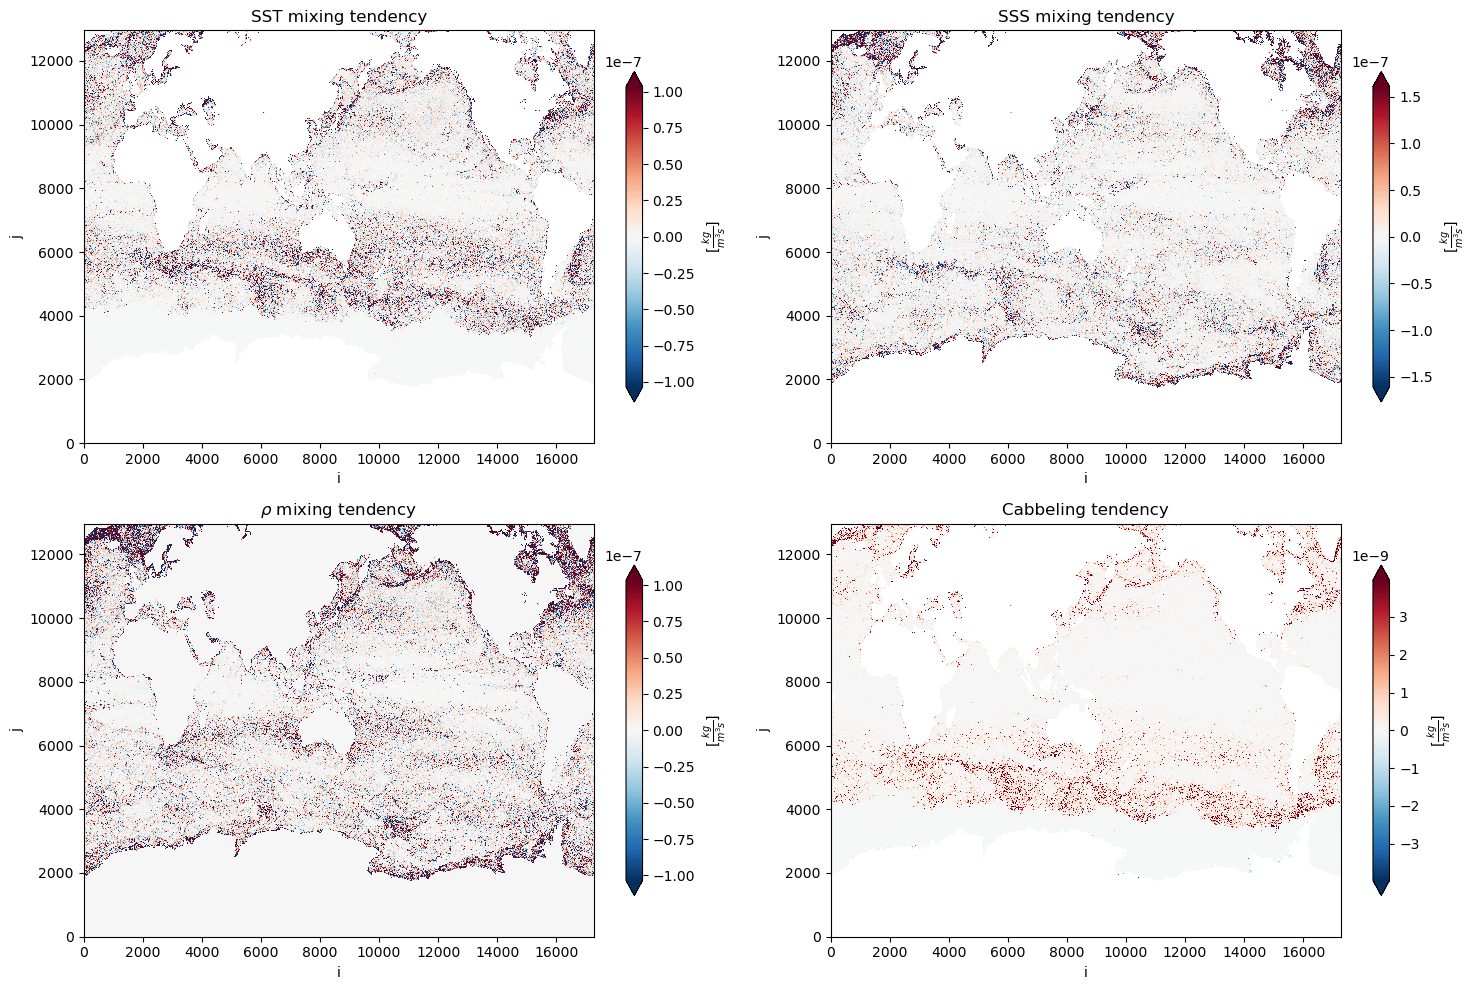

In [26]:
#plot all four terms
fig, ax = plt.subplots(2,2, figsize=(15,10))

(SST_lap*drhodt).isel(time=0).plot(robust=True, ax=ax[0,0], 
                                 cbar_kwargs=kwargs)
ax[0,0].set_title('SST mixing tendency')
(SSS_lap*drhods).isel(time=0).plot(robust=True, ax=ax[0,1], 
                                 cbar_kwargs=kwargs)
ax[0,1].set_title('SSS mixing tendency')
(rho_lap).isel(time=0).plot(robust=True, ax=ax[1,0], 
                                 cbar_kwargs=kwargs)
ax[1,0].set_title(r'$\rho$ mixing tendency')
(cabbeling).isel(time=0).plot(robust=True, ax=ax[1,1], 
                                   cbar_kwargs=kwargs)
ax[1,1].set_title('Cabbeling tendency')

plt.tight_layout();

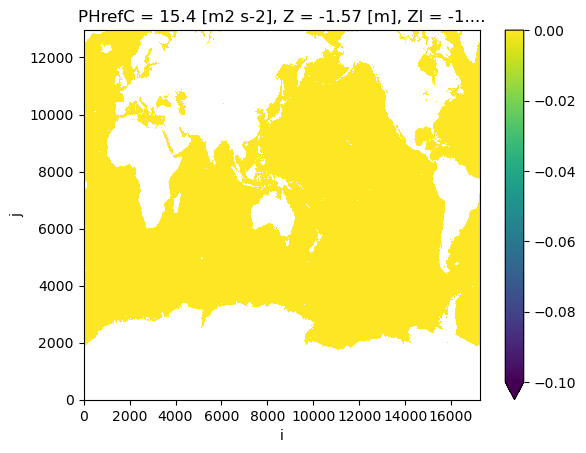

In [27]:
(rho_lap - dens_tend + cabbeling).isel(time=100).plot(robust=True, vmin=1e-10)

# 4) Histogram

In [83]:
rmask = mask
#mask_bins = np.arange(rmask.min()-0.5, rmask.max()+0.5)
mask_bins = np.array([ 0.5,  1.5,  2.5,  3.5,  4.5,  5.5,  6.5,  7.5,  8.5,  9.5, 10.5, 12.5, 99.5])
rho = rho_imported.rho_test # tendencies.rho
delta_rho = 0.1
rho_bins = np.arange(1015, 1035, delta_rho)

In [85]:
from xhistogram.xarray import histogram
def histogram_function(ds, prefix, ocean, variable):
    """Generalized xhistogram's histogram function 
    for mixing tendency terms"""
    hist = histogram(rho.rename('rho0'), bins=[rho_bins],
                     weights=(ds[prefix+variable].fillna(0.)*(avg_mld*coord.area_t).where(mask==ocean).fillna(0.)),
                     dim=['xt_ocean', 'yt_ocean'])
    return hist / delta_rho

In [86]:
def global_hist_func(ds, variable):
    hist = histogram(rho.rename('rho0'), bins=[rho_bins],
                    weights=(ds[variable].fillna(0.)*(avg_mld*coord.area_t).fillna(0.)),
                    dim=['xt_ocean', 'yt_ocean']) / delta_rho
    return hist

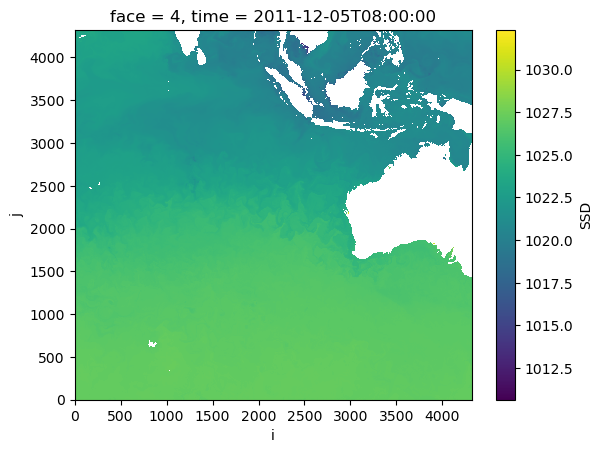

In [50]:
ds.SSD.where(mask).isel(face=4, time=2000).plot()

In [23]:
mask = coords.hFacC>0
delta_rho = 0.1
rho_bins = np.arange(1015, 1035, delta_rho)
avg_mld = 50 #m
weights = coords.rA*avg_mld

In [38]:
from xhistogram.xarray import histogram
def global_hist_func(ds_face, variable, face_layer=None):
    
    slct = dict(face=face_layer)
    masking = mask.isel(**slct)
    
    hist = (histogram(ds.SSD.where(mask).isel(**slct).rename('rho0'), 
                      bins=[rho_bins],
                      weights=(ds_face[variable].where(masking).fillna(0.)*weights.where(mask).isel(**slct).fillna(0.)),
                      dim=['i', 'j']) / delta_rho)
    return hist

In [46]:
ds.SSD.where(mask).isel(face=4)

<xarray.DataArray 'SSD' (time: 9030, j: 4320, i: 4320)>
dask.array<getitem, shape=(9030, 4320, 4320), dtype=float64, chunksize=(1, 4320, 4320), chunktype=numpy.ndarray>
Coordinates:
    face     int64 4
  * i        (i) int64 0 1 2 3 4 5 6 7 ... 4313 4314 4315 4316 4317 4318 4319
  * j        (j) int64 0 1 2 3 4 5 6 7 ... 4313 4314 4315 4316 4317 4318 4319
  * time     (time) datetime64[ns] 2011-09-13 ... 2012-09-23T05:00:00

In [47]:
test = histogram(ds.SSD.where(mask).isel(face=4).rename('rho0'),
          bins=[rho_bins],
          weights=(face4.sss.where(mask.isel(face=4))),
          dim=['i', 'j'])

In [58]:
test = histogram(ds.SSD.where(mask).isel(face=4).rename('rho0'),
          bins=[rho_bins],
          weights=(ds.SST.where(mask).isel(face=4)),
          dim=['j', 'i'])

In [59]:
test

<xarray.DataArray 'histogram_rho0' (time: 9030, rho0_bin: 199)>
dask.array<sum-aggregate, shape=(9030, 199), dtype=float32, chunksize=(1, 199), chunktype=numpy.ndarray>
Coordinates:
  * time      (time) datetime64[ns] 2011-09-13 ... 2012-09-23T05:00:00
  * rho0_bin  (rho0_bin) float64 1.015e+03 1.015e+03 ... 1.035e+03 1.035e+03

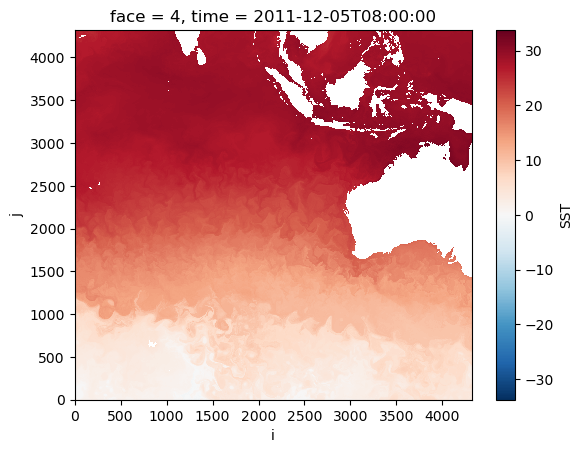

In [56]:
ds.SST.where(mask).isel(face=4, time=2000).plot()

In [60]:
test.isel(time=2000).plot()

ZeroDivisionError: integer division or modulo by zero

In [31]:
all_tendencies = list(face0.data_vars)

In [32]:
test_hist = xr.merge([global_hist_func(face0, var, 0).rename('OMEGA_' + var) for var in all_tendencies])

In [33]:
test_hist

<xarray.Dataset>
Dimensions:          (time: 9030, rho0_bin: 199)
Coordinates:
  * time             (time) datetime64[ns] 2011-09-13 ... 2012-09-23T05:00:00
  * rho0_bin         (rho0_bin) float64 1.015e+03 1.015e+03 ... 1.035e+03
Data variables:
    OMEGA_sst        (time, rho0_bin) float64 dask.array<chunksize=(1, 199), meta=np.ndarray>
    OMEGA_sss        (time, rho0_bin) float64 dask.array<chunksize=(1, 199), meta=np.ndarray>
    OMEGA_rho_lap    (time, rho0_bin) float64 dask.array<chunksize=(1, 199), meta=np.ndarray>
    OMEGA_cabbeling  (time, rho0_bin) float64 dask.array<chunksize=(1, 199), meta=np.ndarray>

In [34]:
test_hist.OMEGA_cabbeling.isel(time=2010).plot();

ZeroDivisionError: integer division or modulo by zero

In [61]:
res_hist = test_hist.OMEGA_rho_lap + test_hist.OMEGA_cabbeling - test_hist.OMEGA_sss - test_hist.OMEGA_sst

In [59]:
res_hist.isel(time=2010).plot();

ZeroDivisionError: integer division or modulo by zero

## 5) Save the four terms to dataset <a class="anchor" id="fourth-bullet"> </a>

In [ ]:
client.restart()

In [28]:
import json
with open('/home/jovyan/pangeo-181919-f141378dc975.json') as token_file:
    token = json.load(token_file)
gcfs_w_token = gcsfs.GCSFileSystem(token=token)

In [33]:
tracers = xr.merge([SST_lap.rename('sst'), SSS_lap.rename('sss')])
rho_cab = xr.merge([rho_lap.rename('rho_lap'), cabbeling.rename('cabbeling')])
drhodts = xr.merge([drhodt.rename('drhodt'), drhods.rename('drhods')])

In [32]:
#uploading drhodt tendency for full run
gcsmap_drhodt_tendencies = gcfs_w_token.get_mapper('pangeo-tmp/stb2145/LLC4320/datasets/drhodts.zarr')
drhodts.to_zarr(gcsmap_drhodt_tendencies, mode='w')

In [ ]:
gcsmap_tracers = gcfs_w_token.get_mapper('pangeo-tmp/stb2145/LLC4320/datasets/tracer_tendencies.zarr')
tracers.to_zarr(gcsmap_tracers, mode='w')

In [ ]:
gcsmap_rho_cab = gcfs_w_token.get_mapper('pangeo-tmp/stb2145/LLC4320/datasets/rho_cab_tendencies.zarr')
rho_cab.to_zarr(gcsmap_rho_cab, mode='w')

In [55]:
cluster.close()
client.close()